In [1]:
from google.colab import files

In [2]:
!pip -q install kaggle pyspark pyarrow

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\n  "username": "vadimsokol",\n  "key": "KGAT_1943f2f81f04e39172723dd31c2ac3c0"\n}\n'}

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
!kaggle datasets list | head


ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                             Chocolate Sales                                         468320  2026-01-04 14:23:35.490000          12945        221  1.0              
aliiihussain/amazon-sales-dataset                               Amazon_Sales_Dataset                                   1297759  2026-02-01 11:37:12.353000           1275         35  1.0              
nalisha/e-commerce-sales-and-profit-analysis-dataset            E-Commerce Sales & Profit Analysis Dataset               42383  2026-01-31 06:51:11.350000            774         27  1.0              


In [9]:
DATASET = "mohamedbakhet/amazon-books-reviews"

!mkdir -p /content/data
!kaggle datasets download -d {DATASET} -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
100% 1.06G/1.06G [00:13<00:00, 107MB/s]
100% 1.06G/1.06G [00:13<00:00, 87.5MB/s]


In [10]:
!ls -lah /content/data


total 2.9G
drwxr-xr-x 2 root root 4.0K Feb  4 14:12 .
drwxr-xr-x 1 root root 4.0K Feb  4 14:11 ..
-rw-r--r-- 1 root root 173M Feb  4 14:12 books_data.csv
-rw-r--r-- 1 root root 2.7G Feb  4 14:12 Books_rating.csv


In [102]:
DATA_DIR = "/content/data"
RATINGS_CSV = f"{DATA_DIR}/Books_rating.csv"
BOOKS_CSV = f"{DATA_DIR}/books_data.csv"

# just to save runtime
USE_FULL_DATA = False
SAMPLE_FRAC = 0.20
SEED = 12345


In [103]:
import pandas as pd
import matplotlib.pyplot as plt


In [104]:
K_EVAL = 10 # report size
MAX_USERS_EVAL = 2000 # cap for speed
MIN_TEST_POS = 1 # user must have at least this many test items
MIN_TRAIN_ITEMS = 3 # need some history to recommend


In [105]:
# Start the SPark session

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("amd-recsys-books")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")


In [106]:
# Load book ratings into Spark:
from pyspark.sql import functions as F

ratings = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .csv(RATINGS_CSV)
)

ratings.printSchema()
ratings.show(5, truncate=False)


root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

+----------+------------------------------+-----+--------------+--------------------------------------+------------------+------------+-----------+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [107]:
# check the columns to understand what's inside

cols = {c.lower(): c for c in ratings.columns}
cols

{'id': 'Id',
 'title': 'Title',
 'price': 'Price',
 'user_id': 'User_id',
 'profilename': 'profileName',
 'review/helpfulness': 'review/helpfulness',
 'review/score': 'review/score',
 'review/time': 'review/time',
 'review/summary': 'review/summary',
 'review/text': 'review/text'}

In [108]:
# Normalize and select core columns
from pyspark.sql import functions as functions

score_string = functions.regexp_extract(functions.col("review/score"), r"([0-9]+(\.[0-9]+)?)", 1)

ratings_0 = (
    ratings
    .select(
        functions.col("User_id").alias("user_id"),
        functions.col("Id").alias("book_id"),
        # safe numeric extraction for odd strings
        functions.when(score_string != "", score_string.cast("double")).otherwise(F.lit(None).cast("double")).alias("rating"),
        functions.col("Title").alias("title"),
    )
    .dropna(subset=["user_id", "book_id", "rating"])
)

ratings_0.select("rating").describe().show()
ratings_0.show(3, truncate=False)


+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|           2433202|
|   mean|2029.6013891366192|
| stddev|1580342.9802411501|
|    min|               0.0|
|    max|        1.295568E9|
+-------+------------------+

+--------------+----------+------+------------------------------+
|user_id       |book_id   |rating|title                         |
+--------------+----------+------+------------------------------+
|AVCGYZL8FQQTD |1882931173|4.0   |Its Only Art If Its Well Hung!|
|A30TK6U7DNS82R|0826414346|5.0   |Dr. Seuss: American Icon      |
|A3UH4UZ4RSVO82|0826414346|5.0   |Dr. Seuss: American Icon      |
+--------------+----------+------+------------------------------+
only showing top 3 rows


In [109]:
# clear bad formed data for ratings, first got 10^8 score

# keep only realistic star ratings
ratings_1 = ratings_0.filter((F.col("rating") >= 1.0) & (F.col("rating") <= 5.0))

ratings_1.select("rating").describe().show()


+-------+-----------------+
|summary|           rating|
+-------+-----------------+
|  count|          2426292|
|   mean|4.222532572336718|
| stddev|1.183760589211074|
|    min|              1.0|
|    max|              5.0|
+-------+-----------------+



In [110]:
ratings.select("review/score").show(5, truncate=False)
ratings.select("review/helpfulness").show(5, truncate=False)


+------------+
|review/score|
+------------+
|4.0         |
|5.0         |
|5.0         |
|4.0         |
|4.0         |
+------------+
only showing top 5 rows
+------------------+
|review/helpfulness|
+------------------+
|7/7               |
|10/10             |
|10/11             |
|7/7               |
|3/3               |
+------------------+
only showing top 5 rows


In [111]:
# Sample and reduce sparcity, for speed

ratings = ratings_1
if not USE_FULL_DATA:
    ratings = ratings.sample(False, SAMPLE_FRAC, seed=SEED)

MIN_USER_RATINGS = 5
MIN_BOOK_RATINGS = 5

user_count = ratings.groupBy("user_id").count().withColumnRenamed("count", "user_count")
book_count = ratings.groupBy("book_id").count().withColumnRenamed("count", "book_count")

ratings = (
    ratings.join(user_count, "user_id")
     .join(book_count, "book_id")
     .filter((functions.col("user_count") >= MIN_USER_RATINGS) & (functions.col("book_count") >= MIN_BOOK_RATINGS))
     .select("user_id", "book_id", "rating", "title")
)

print("rows:", ratings.count())
print("users:", ratings.select("user_id").distinct().count())
print("books:", ratings.select("book_id").distinct().count())

ratings.cache()


rows: 85603
users: 9795
books: 13660


DataFrame[user_id: string, book_id: string, rating: double, title: string]

In [112]:
rating_counts = (
    ratings.groupBy("rating").count()
           .orderBy("rating")
           .toPandas()
)

rating_counts


,rating,count
0,1.0,2782
1,2.0,3749
2,3.0,9257
3,4.0,21766
4,5.0,48049


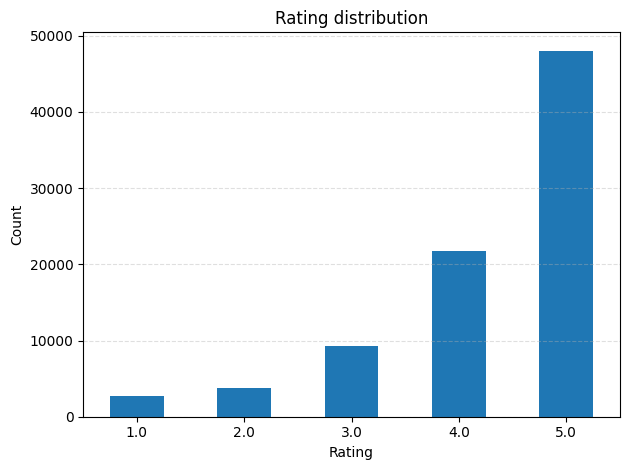

In [113]:
ax = rating_counts.plot(kind="bar", x="rating", y="count", legend=False, rot=0)
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
ax.set_title("Rating distribution")
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [114]:
from pyspark.sql import functions as F

ratings.groupBy("book_id").count().orderBy(F.col("count").desc()).show(20)
ratings.groupBy("user_id").count().orderBy(F.col("count").desc()).show(20)


+----------+-----+
|   book_id|count|
+----------+-----+
|0141804459|  178|
|B000GQG7D2|  171|
|B000C1X8JC|  168|
|B000NDSX6C|  168|
|0786135034|  167|
|B000F6H01Q|  165|
|B000ILIJE0|  164|
|B000Q032UY|  164|
|B000GQG5MA|  164|
|B000GDLGSG|  164|
|1844560333|  161|
|0451513967|  159|
|B000NWQXBA|  159|
|0435126075|  158|
|1901768945|  157|
|8188280046|  157|
|B000EVI8O0|  155|
|1566190932|  150|
|B000H9R1Q0|  148|
|B000PC54NG|  145|
+----------+-----+
only showing top 20 rows
+--------------+-----+
|       user_id|count|
+--------------+-----+
|A1D2C0WDCSHUWZ|  568|
|   AFVQZQ8PW0L|  290|
|A14OJS0VWMOSWO|  266|
|A20EEWWSFMZ1PN|  212|
|A1X8VZWTOG8IS6|  211|
| AHD101501WCN1|  184|
|A1K1JW1C5CUSUZ|  179|
|A1EKTLUL24HDG8|  145|
|A1G37DFO8MQW0M|  143|
|A1N1YEMTI9DJ86|  139|
|A3QVAKVRAH657N|  136|
| AHXAPVSHPJ6OJ|  132|
|A2F6N60Z96CAJI|  131|
|A1L43KWWR05PCS|  129|
|A1T17LMQABMBN5|  117|
|A319KYEIAZ3SON|  113|
|A3M174IC0VXOS2|  111|
| AJQ1S39GZBKUG|  109|
|A3LKWMM12AF0PU|  108|
|A28WJUJF6D2U

In [115]:
# Baseline recommender by popularity
# Check it to compare later

MIN_REVIEWS_FOR_POPULARITY = 10

popular = (
    ratings.groupBy("book_id", "title")
     .agg(functions.count("*").alias("n"), functions.avg("rating").alias("average_rating"))
     .filter(functions.col("n") >= MIN_REVIEWS_FOR_POPULARITY)
     .orderBy(functions.col("average_rating").desc(), functions.col("n").desc())
)

popular.show(20, truncate=False)


+----------+-----------------------------------------------------------------------------------------+---+-----------------+
|book_id   |title                                                                                    |n  |average_rating   |
+----------+-----------------------------------------------------------------------------------------+---+-----------------+
|B000OZRZ90|Milton's Paradise Lost                                                                   |12 |5.0              |
|1854596209|Hamlet (The Shakespeare Folios)                                                          |11 |5.0              |
|B000JWHH32|The Jungle Book (Companion Library)                                                      |11 |5.0              |
|B0007G64NO|The Screwtape letters & Screwtape proposes a toast (Time reading program special edition)|10 |5.0              |
|B0007J8XJ4|The varieties of religious experience: A study in human nature (Gifford lectures)        |10 |5.0              |


In [116]:
# Train test split
train_df, test_df = ratings.randomSplit([0.8, 0.2], seed=SEED)

train_df = train_df.cache()
test_df  = test_df.cache()

print("train:", train_df.count(), "test:", test_df.count())


train: 68323 test: 17280


Item-item colaborative filtering

In [117]:
# build user to list of pairs item, rating from train data

# resilient distr dataset
train_rdd = train_df.select("user_id", "book_id", "rating").rdd

user_items = (
    train_rdd
    .map(lambda row: (row["user_id"], (row["book_id"], float(row["rating"]))))
    .groupByKey()
    .mapValues(list)
)


In [118]:
# Generate item pairs per user and get stats aggregation

import itertools
import math
# safety cap for many reviews
MAX_ITEMS_PER_USER = 50

def make_pairs(items):
    # items are list of (book_id, rating)
    if len(items) > MAX_ITEMS_PER_USER:
        items = items[:MAX_ITEMS_PER_USER]  # deterministic cap, todo: improve
    out = []
    for (i, ri), (j, rj) in itertools.combinations(items, 2):
        if i == j:
            continue
        a, b = (i, j) if i < j else (j, i)
        ra, rb = (ri, rj) if i < j else (rj, ri)
        out.append(((a, b), (ra*rb, ra*ra, rb*rb, 1)))
    return out

pair_stats = (
    user_items
    .flatMap(lambda x: make_pairs(x[1]))
    .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3]))
)


In [119]:
# Compute cosine similarity

MIN_COMMON_USERS = 2

similarities = (
    pair_stats
    .filter(lambda kv: kv[1][3] >= MIN_COMMON_USERS)
    .mapValues(lambda v: (
        v[0] / (math.sqrt(v[1]) * math.sqrt(v[2]) + 1e-12),  # cosine similarity
        v[3]  # common users
    ))
)

print("number of item pairs with common users >= min common users:", similarities.count())
print("sample similarity:", similarities.take(5))


number of item pairs with common users >= min common users: 22493
sample similarity: [(('1420926810', '1570020981'), (0.9374252720097401, 2)), (('B00069X44Y', 'B00086KNY4'), (0.9999999999999798, 2)), (('0792717848', 'B00005QTHG'), (0.8531145054348057, 3)), (('0520050894', 'B000GTEU8I'), (0.9999999999999908, 5)), (('B000JQXNSQ', 'B000NNOTXI'), (0.890870806374732, 3))]


In [182]:
BETA = 0  # larger = more conservative

def significance(sim, cnt, beta=BETA):
    shrink = cnt / (cnt + beta)
    sim_w = sim * shrink
    return sim_w, shrink, cnt


In [183]:
# KNN per item, top

K = 30

neighbors = similarities.flatMap(lambda kv: [
    (kv[0][0], (kv[0][1],) + significance(kv[1][0], kv[1][1])),  # i -> (j, sim_w, shrink, cnt)
    (kv[0][1], (kv[0][0],) + significance(kv[1][0], kv[1][1]))   # j -> (i, sim_w, shrink, cnt)
])

def topk(xs, k=K):
    # t[1] is sim'
    xs = sorted(xs, key=lambda t: t[1], reverse=True)
    return xs[:k]

item_neighbors = neighbors.groupByKey().mapValues(lambda xs: topk(list(xs), K))

# collect is ok at this sample size
item_neighbors_map = dict(item_neighbors.collect())
print("items with neighbor lists:", len(item_neighbors_map))


items with neighbor lists: 4647


In [184]:
# Broadcast!!

broadcast_neighbours = spark.sparkContext.broadcast(item_neighbors_map)

In [185]:
train_ui = (
    train_df.groupBy("user_id", "book_id")
            .agg(functions.avg("rating").alias("rating"))
)

# Broadcast user history from train
user_history_map = dict(
    train_ui.rdd
    .map(lambda r: (r["user_id"], (r["book_id"], float(r["rating"]))))
    .groupByKey()
    .mapValues(list)
    .collect()
)

broadcast_history = spark.sparkContext.broadcast(user_history_map)
print("users in history:", len(user_history_map))


users in history: 9725


In [186]:
import math

def predict_one(user_id, target_item):
    history = broadcast_history.value.get(user_id, [])
    neighbours = broadcast_neighbours.value.get(target_item, [])
    if not history or not neighbours:
        return None

    history_map = dict(history)

    num = 0.0
    den = 0.0
    for j, sim_w, shrink, cnt in neighbours:
        if j in history_map:
            num += sim_w * history_map[j]
            den += abs(sim_w)

    if den < 1e-9:
        return None

    prediction = num / den
    return max(1.0, min(5.0, prediction))

predicted_test_true = (
    test_df.select("user_id","book_id","rating").rdd
    .map(lambda r: (predict_one(r["user_id"], r["book_id"]), float(r["rating"])))
    .filter(lambda x: x[0] is not None)
)

mse = predicted_test_true.map(lambda x: (x[0] - x[1])**2).mean()
rmse = math.sqrt(mse)

predicted_count = predicted_test_true.count()
test_count = test_df.count()
coverage = predicted_count / test_count

print("RMSE:", rmse)
print("Coverage:", coverage)
print("Predicted test points:", predicted_count, "/", test_count)


RMSE: 0.4215375035604698
Coverage: 0.37471064814814814
Predicted test points: 6475 / 17280


COverage improved significantly.
Now Baseline RMSE

In [187]:
import math
from pyspark.sql import functions as functions

global_mean = train_df.agg(functions.avg("rating")).first()[0]
baseline_mse = test_df.select("rating").rdd.map(lambda r: (float(r[0]) - global_mean)**2).mean()
baseline_rmse = math.sqrt(baseline_mse)

print("Global mean:", global_mean)
print("Baseline RMSE (global mean):", baseline_rmse)


Global mean: 4.269396835619045
Baseline RMSE (global mean): 1.037404870258155


In [188]:
# Top N recommendations for a user
book_titles = dict(
    ratings.select("book_id", "title")
           .dropna(subset=["title"])
           .dropDuplicates(["book_id"])
           .rdd.map(lambda r: (r["book_id"], r["title"]))
           .collect()
)

print("book titles len:", len(book_titles))


book titles len: 13659


In [189]:
def recommend_for_user(user_id, N=10):
    history = broadcast_history.value.get(user_id, [])
    # cold start
    if not history:
        return []

    seen = set(i for i, _ in history)
    # item -> (num, den, contribs)
    scores = {}

    for i, r_ui in history:
        for j, sim_w, shrink, count in broadcast_neighbours.value.get(i, []):
            if j in seen:
                continue
            num, den, c = scores.get(j, (0.0, 0.0, 0))
            num += sim_w * r_ui
            den += abs(sim_w)
            c += 1
            scores[j] = (num, den, c)

    predictions = []
    for j, (num, den, c) in scores.items():
        if den > 1e-9 and c >= 2:  # small filter makes output nicer
            prediction = max(1.0, min(5.0, num / den))
            predictions.append((j, prediction, c))

    predictions.sort(key=lambda x: (x[1], x[2]), reverse=True)
    return predictions[:N]


In [190]:
# Let's pick one of the users and ptint top rated

def top_rated_unique(user_id, n=10):
    history = broadcast_history.value.get(user_id, [])
    # sort by rating, then unique by book_id
    history = sorted(history, key=lambda x: x[1], reverse=True)
    seen = set()
    out = []
    for bid, r in history:
        if bid in seen:
            continue
        seen.add(bid)
        out.append((bid, r))
        if len(out) >= n:
            break
    return out

USER = "A1D2C0WDCSHUWZ"
for bid, r in top_rated_unique(USER, 10):
    print(f"{r:.1f}  {bid}  -  {book_titles.get(bid, '<no title>')}")


5.0  0020554303  -  House of Mirth
5.0  0060765461  -  The Lion, the Witch and the Wardrobe Movie Tie-in Edition (The Chronicles of Narnia)
5.0  0075543893  -  Little Women
5.0  0140351310  -  Jane Eyre: Complete and Unabridged (Puffin Classics)
5.0  0140860428  -  Jane Eyre (Penguin Classics)
5.0  0140860436  -  The Age of Innocence (Classic, 20th-Century, Audio)
5.0  0141804459  -  Pride & Prejudice (Penguin Classics)
5.0  0141804564  -  Persuasion (Penguin Audio Classics)
5.0  0141804572  -  Sense & Sensibility Cds (Penguin Classics)
5.0  0192503561  -  Persuasion (World's Classics)


In [191]:
# SO, he is hitting 5/5 often
# Let's check what user liked


recommendations = recommend_for_user(USER, 10)
for bid, prediction, c in recommendations:
    print(f"{prediction:.3f} (from {c} neighbour)  {bid}  -  {book_titles.get(bid, '<no title>')}")


5.000 (from 23 neighbour)  B000G1TD92  -  Persuasion
5.000 (from 18 neighbour)  1576463451  -  Persuasion
5.000 (from 15 neighbour)  0748608370  -  Treasure Island
5.000 (from 13 neighbour)  1578400317  -  Treasure Island (Classic Illustrated)
5.000 (from 13 neighbour)  1556909330  -  Dune
5.000 (from 12 neighbour)  1559350334  -  The Lord of the Rings: The Fellowship of the Ring (BBC Audio Collection)
5.000 (from 11 neighbour)  0808510258  -  Harper Lee's To Kill a Mockingbird (Barron's Book Notes)
5.000 (from 11 neighbour)  0192817728  -  The Secret Garden (Worlds Classics)
5.000 (from 11 neighbour)  B000N28H2I  -  The Two Towers
5.000 (from 9 neighbour)  0681994940  -  Great Expectations


In [192]:
# Let's check abother user

USER = "A14OJS0VWMOSWO"
for bid, r in top_rated_unique(USER, 40):
    print(f"{r:.1f}  {bid}  -  {book_titles.get(bid, '<no title>')}")

recommendations = recommend_for_user(USER, 40)
for bid, prediction, c in recommendations:
    print(f"{prediction:.3f} (from {c} neighbour)  {bid}  -  {book_titles.get(bid, '<no title>')}")



5.0  0066212448  -  Wittgenstein's Poker: The Story of a Ten-Minute Argument Between Two Great Philosophers
5.0  0140298401  -  Forever Liesl: A Memoir of The Sound of Music
5.0  0156949601  -  The Waves
5.0  0192817728  -  The Secret Garden (Worlds Classics)
5.0  0192818201  -  THE WAVES (WORLD'S CLASSICS)
5.0  0201722089  -  The Photoshop 6 WOW! Book
5.0  0307165205  -  The Children's Bible
5.0  0307280721  -  Eldest (Inheritance, Book 2)
5.0  0316785644  -  The Fig Eater
5.0  0333908937  -  ABC Murders
5.0  0340283947  -  Alice in Wonderland
5.0  0340283955  -  Alice in Wonderland
5.0  0345283937  -  Safire's Political Dictionary
5.0  0345325699  -  Working
5.0  0374336857  -  Jitterbug Jam (New York Times Best Illustrated Books (Awards))
5.0  0375414126  -  John James Audubon: The Making of an American
5.0  0375831908  -  Little Golden Book Collection: Farm Tales (Little Golden Book Treasury)
5.0  0375831916  -  Traction Man Is Here! (Boston Globe-Horn Book Awards (Awards))
5.0  03

In [193]:
# recommend for user and don’t clip at 5.0 for display
def recommend_for_user(user_id, N=10):
    history = broadcast_history.value.get(user_id, [])
    if not history:
        return []

    seen = set(i for i, _ in history)
    scores = {}

    for i, r_ui in history:
        for j, sim_w, shrink, count in broadcast_neighbours.value.get(i, []):
            if j in seen:
                continue
            num, den, c = scores.get(j, (0.0, 0.0, 0))
            num += sim_w * r_ui
            den += abs(sim_w)
            c += 1
            scores[j] = (num, den, c)

    predictions = []
    for j, (num, den, c) in scores.items():
        if den > 1e-9 and c >= 2:
            raw = num / den
            clipped = max(1.0, min(5.0, raw))
            predictions.append((j, raw, clipped, c))

    # sort by clipped then contribs
    predictions.sort(key=lambda x: (x[2], x[3]), reverse=True)
    return predictions[:N]

recommendations = recommend_for_user(USER, 200)
for bid, raw, clipped, c in recommendations:
    print(f"{clipped:.3f} (raw {raw:.3f}, from {c} neigh)  {bid}  -  {book_titles.get(bid, '<no title>')}")


5.000 (raw 5.000, from 5 neigh)  0460872702  -  Great Gatsby (Everyman)
5.000 (raw 5.000, from 4 neigh)  140505347X  -  Alice's Adventures in Wonderland
5.000 (raw 5.000, from 3 neigh)  B0006AGHH4  -  Uncle Tom's cabin;: Or, Life among the lowly
5.000 (raw 5.000, from 3 neigh)  B0006AQ6MA  -  Ulysses,
5.000 (raw 5.000, from 3 neigh)  0140351310  -  Jane Eyre: Complete and Unabridged (Puffin Classics)
5.000 (raw 5.000, from 3 neigh)  0517124203  -  Alice's Adventures in Wonderland
5.000 (raw 5.000, from 3 neigh)  0747553688  -  Alice's Adventures in Wonderland
5.000 (raw 5.000, from 3 neigh)  0904724719  -  Alice in Wonderland (Tell tales)
5.000 (raw 5.000, from 3 neigh)  0786261080  -  Alice's Adventures in Wonderland
5.000 (raw 5.000, from 3 neigh)  068983375X  -  Alice's Adventures in Wonderland (Aladdin Classics)
5.000 (raw 5.000, from 3 neigh)  0848809904  -  Lost World
5.000 (raw 5.000, from 3 neigh)  B000MUFLHU  -  The Wonderful Wizard Of Oz
5.000 (raw 5.000, from 3 neigh)  B000H

In [194]:
# Mean centered item item
from pyspark.sql import functions as F

user_mean_map = dict(
    train_df.groupBy("user_id")
            .agg(F.avg("rating").alias("mu"))
            .rdd.map(lambda r: (r["user_id"], float(r["mu"])))
            .collect()
)
bum = spark.sparkContext.broadcast(user_mean_map)

print("users with mean:", len(user_mean_map))


users with mean: 9725


In [195]:
# Mean centered predictor

def predict_one_centered(user_id, target_item):
    history = broadcast_history.value.get(user_id, [])
    neighbours = broadcast_neighbours.value.get(target_item, [])
    if not history or not neighbours:
        return None

    mu = bum.value.get(user_id, 4.0)
    history_map = dict(history)

    num = 0.0
    den = 0.0
    contribution = 0

    for j, sim_w, shrink, count in neighbours:
        if j in history_map:
            num += sim_w * (history_map[j] - mu)   # deviation from user mean
            den += abs(sim_w)
            contribution += 1

    if den < 1e-9:
        return None

    prediction = mu + num / den
    prediction = max(1.0, min(5.0, prediction))
    return prediction, contribution


In [196]:
# recompute RMSE and coverage with mean centered predictor
import math

predicted_true = (
    test_df.select("user_id","book_id","rating").rdd
    .map(lambda r: (predict_one_centered(r["user_id"], r["book_id"]), float(r["rating"])))
    .filter(lambda x: x[0] is not None)
    .map(lambda x: (x[0][0], x[1]))  # keep only pred, true
)

mse = predicted_true.map(lambda x: (x[0] - x[1])**2).mean()
rmse_centered = math.sqrt(mse)

predicted_count = predicted_true.count()
test_count = test_df.count()
coverage_centered = predicted_count / test_count

print("Centered RMSE:", rmse_centered)
print("Centered Coverage:", coverage_centered)
print("Predicted:", predicted_count, "/", test_count)


Centered RMSE: 0.4215375035604698
Centered Coverage: 0.37471064814814814
Predicted: 6475 / 17280


In [197]:
# Mean centered top N recommendations
def recommend_for_user_centered(user_id, N=10, min_contrib=2):
    history = broadcast_history.value.get(user_id, [])
    if not history:
        return []

    mu = bum.value.get(user_id, 4.0)
    seen = set(i for i, _ in history)
    history_map = dict(history)

    scores = {}  # item -> (num, den, contrib)
    for i, r_ui in history:
        for j, sim_w, shrink, count in broadcast_neighbours.value.get(i, []):
            if j in seen:
                continue
            num, den, c = scores.get(j, (0.0, 0.0, 0))
            num += sim_w * (history_map[i] - mu)   # use deviation
            den += abs(sim_w)
            c += 1
            scores[j] = (num, den, c)

    predictions = []
    for j, (num, den, c) in scores.items():
        if den > 1e-9 and c >= min_contrib:
            prediction = mu + num / den
            prediction = max(1.0, min(5.0, prediction))
            predictions.append((j, prediction, c))

    predictions.sort(key=lambda x: (x[1], x[2]), reverse=True)
    return predictions[:N]


In [198]:
USER = "A3M174IC0VXOS2"
recommendations = recommend_for_user_centered(USER, 100)

for bid, prediction, c in recommendations:
    print(f"{prediction:.3f} (from {c} neigh)  {bid}  -  {book_titles.get(bid, '<no title>')}")


5.000 (from 3 neigh)  0736605010  -  Wuthering Heights
5.000 (from 3 neigh)  B000P4Q3JS  -  Wuthering Heights (The Franklin Library)
5.000 (from 3 neigh)  0435126083  -  Wuthering Heights (New Windmill)
5.000 (from 3 neigh)  1590862899  -  The Scarlet Letter
5.000 (from 3 neigh)  B000F6H01Q  -  Pride and Prejudice
5.000 (from 3 neigh)  157646346X  -  Persuasion
5.000 (from 3 neigh)  B000NPAT6W  -  Narrative of the Life of Frederick Douglass, An American Slave. Written by Himself
5.000 (from 3 neigh)  B000L3AP9C  -  A Tree Grows in Brooklyn
5.000 (from 3 neigh)  B0006BV6RY  -  Wuthering Heights (College classics in English)
5.000 (from 3 neigh)  B0006DXUU8  -  A Christmas carol: In prose
5.000 (from 3 neigh)  0742623157  -  A Christmas Carol, in Prose: Being a Ghost Story of Christmas (Collected Works of Charles Dickens)
5.000 (from 3 neigh)  0721417299  -  Christmas Carol (Ladybird Classics)
5.000 (from 3 neigh)  B000056MLJ  -  A Christmas Carol [One Voice Recordings Edition]
5.000 (fr

In [199]:
def explain_recommendation(user_id, target_item, top_m=3):
    history = broadcast_history.value.get(user_id, [])
    mu = bum.value.get(user_id, 4.0)
    history_map = dict(history)

    reasons = []
    for j, sim_w, shrink, cnt in broadcast_neighbours.value.get(target_item, []):
        if j in history_map:
            contrib = sim_w * (history_map[j] - mu)
            reasons.append((j, sim_w, shrink, cnt, history_map[j], contrib))

    reasons.sort(key=lambda x: abs(x[5]), reverse=True)  # contrib is now x[5]
    return reasons[:top_m]


USER = "A3M174IC0VXOS2"
recommendations = recommend_for_user_centered(USER, 10)

for bid, prediction, c in recommendations:
    print(f"\n{prediction:.3f} (from {c} neigh)  {book_titles.get(bid, bid)}")
    for j, sim_w, shrink, cnt, rj, contrib in explain_recommendation(USER, bid, top_m=3):
        print(
            f"  because: {book_titles.get(j, j)} | "
            f"sim'={sim_w:.3f} (shrink={shrink:.3f}, common={cnt}), your_rating={rj:.1f}, contrib={contrib:+.3f}"
        )



5.000 (from 3 neigh)  Wuthering Heights
  because: Wuthering Heights | sim'=1.000 (shrink=1.000, common=32), your_rating=5.0, contrib=+0.264
  because: Wuthering Heights (Riverside editions) | sim'=1.000 (shrink=1.000, common=15), your_rating=5.0, contrib=+0.264

5.000 (from 3 neigh)  Wuthering Heights (The Franklin Library)
  because: Wuthering Heights (Riverside editions) | sim'=1.000 (shrink=1.000, common=16), your_rating=5.0, contrib=+0.264
  because: The book of three | sim'=1.000 (shrink=1.000, common=2), your_rating=5.0, contrib=+0.264

5.000 (from 3 neigh)  Wuthering Heights (New Windmill)
  because: Wuthering Heights | sim'=1.000 (shrink=1.000, common=16), your_rating=5.0, contrib=+0.264
  because: Wuthering Heights (Riverside editions) | sim'=1.000 (shrink=1.000, common=11), your_rating=5.0, contrib=+0.264

5.000 (from 3 neigh)  The Scarlet Letter
  because: Wuthering Heights (Riverside editions) | sim'=1.000 (shrink=1.000, common=2), your_rating=5.0, contrib=+0.264
  becaus

In [200]:
from pyspark.sql import functions as functions

train_df.groupBy("rating").count().orderBy("rating").show()


+------+-----+
|rating|count|
+------+-----+
|   1.0| 2195|
|   2.0| 2997|
|   3.0| 7411|
|   4.0|17324|
|   5.0|38396|
+------+-----+



In [201]:
USER = "A3M174IC0VXOS2"
print("user mean:", bum.value.get(USER))


user mean: 4.736263736263736


In [202]:
def recommend_for_user_ranked(user_id, N=10, min_contrib=2, support_bonus=0.02):
    hist = broadcast_history.value.get(user_id, [])
    if not hist:
        return []

    mu = bum.value.get(user_id, 4.0)
    seen = set(i for i, _ in hist)
    hist_map = dict(hist)

    scores = {}  # item -> (num, den, contrib)
    for i, r_ui in hist:
        for j, sim_w,  shrink, count in broadcast_neighbours.value.get(i, []):
            if j in seen:
                continue
            num, den, c = scores.get(j, (0.0, 0.0, 0))
            num += sim_w * (hist_map[i] - mu)
            den += abs(sim_w)
            c += 1
            scores[j] = (num, den, c)

    out = []
    for j, (num, den, c) in scores.items():
        if den > 1e-9 and c >= min_contrib:
            pred = mu + num / den
            pred = max(1.0, min(5.0, pred))
            rank_score = pred + support_bonus * c   # tie-break
            out.append((j, pred, c, rank_score))

    out.sort(key=lambda x: x[3], reverse=True)
    return out[:N]


In [203]:
USER = "A3M174IC0VXOS2"
recommendations = recommend_for_user_ranked(USER, N=15)

for bid, prediction, c, score in recommendations:
    print(f"score={score:.3f} pred={prediction:.3f} (c={c})  {book_titles.get(bid, bid)}")


score=5.060 pred=5.000 (c=3)  Wuthering Heights
score=5.060 pred=5.000 (c=3)  Wuthering Heights (The Franklin Library)
score=5.060 pred=5.000 (c=3)  Wuthering Heights (New Windmill)
score=5.060 pred=5.000 (c=3)  The Scarlet Letter
score=5.060 pred=5.000 (c=3)  Pride and Prejudice
score=5.060 pred=5.000 (c=3)  Persuasion
score=5.060 pred=5.000 (c=3)  Narrative of the Life of Frederick Douglass, An American Slave. Written by Himself
score=5.060 pred=5.000 (c=3)  A Tree Grows in Brooklyn
score=5.060 pred=5.000 (c=3)  Wuthering Heights (College classics in English)
score=5.060 pred=5.000 (c=3)  A Christmas carol: In prose
score=5.060 pred=5.000 (c=3)  A Christmas Carol, in Prose: Being a Ghost Story of Christmas (Collected Works of Charles Dickens)
score=5.060 pred=5.000 (c=3)  Christmas Carol (Ladybird Classics)
score=5.060 pred=5.000 (c=3)  A Christmas Carol [One Voice Recordings Edition]
score=5.060 pred=5.000 (c=3)  A Christmas Carol (Enriched Classics (Pocket))
score=5.060 pred=5.000 

TopN evaluation

In [204]:
# Build per user train items

# train items per user
train_user_items_df = (
    train_df.select("user_id", "book_id")
            .dropDuplicates()
            .groupBy("user_id")
            .agg(functions.collect_set("book_id").alias("train_items"))
)

# test positives per user
test_user_items_df = (
    test_df.select("user_id", "book_id")
           .dropDuplicates()
           .groupBy("user_id")
           .agg(functions.collect_set("book_id").alias("test_items"))
)

# join and filter users
evaluated_users_df = (
    train_user_items_df.join(test_user_items_df, on="user_id", how="inner")
    .withColumn("n_train", functions.size("train_items"))
    .withColumn("n_test", functions.size("test_items"))
    .filter((functions.col("n_train") >= MIN_TRAIN_ITEMS) & (functions.col("n_test") >= MIN_TEST_POS))
)

print("Eligible evaluated users:", evaluated_users_df.count())

# sample users for speed
evaluated_users_sample = evaluated_users_df.limit(MAX_USERS_EVAL).collect()
print("Evaluating on users:", len(evaluated_users_sample))


Eligible evaluated users: 6321
Evaluating on users: 2000


In [205]:
# Recommendation function that excludes seen items
def recommend_topk_from_train_items(train_items, k=K_EVAL):
    # train_items: list of item_ids the user has in train
    seen = set(train_items)
    scores = {}  # item -> score

    # Spread scores from each seen item to its neighbors
    for i in seen:
        for j, sim_w, shrink, count in broadcast_neighbours.value.get(i, []):
            if j in seen:
                continue
            scores[j] = scores.get(j, 0.0) + sim_w

    # Top-k by score
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [item for item, s in ranked[:k]]


In [206]:
# Compute metrics: precision, recall etc

import math

# Normalized Discounted Cumulative Gain
def ndcg_at_k(recommended, positives, k):
    # binary relevance: 1 if in positives
    dcg = 0.0
    for idx, item in enumerate(recommended[:k], start=1):
        if item in positives:
            dcg += 1.0 / math.log2(idx + 1)

    # ideal DCG: all positives ranked first
    ideal_hits = min(len(positives), k)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, ideal_hits + 1))
    return dcg / idcg if idcg > 0 else 0.0

hits = 0
sum_prec = 0.0
sum_rec = 0.0
sum_ndcg = 0.0
n_users = 0

for row in evaluated_users_sample:
    user = row["user_id"]
    train_items = row["train_items"]
    test_items = set(row["test_items"])

    recommendations = recommend_topk_from_train_items(train_items, k=K_EVAL)
    if not recommendations:
        continue

    recommendations_set = set(recommendations)
    n_hit = len(recommendations_set.intersection(test_items))

    # metrics
    hit_rate = 1 if n_hit > 0 else 0
    precision = n_hit / K_EVAL
    recall = n_hit / len(test_items)

    hits += hit_rate
    sum_prec += precision
    sum_rec += recall
    sum_ndcg += ndcg_at_k(recommendations, test_items, K_EVAL)
    n_users += 1

print("Users evaluated:", n_users)
print(f"HitRate@{K_EVAL}: {hits / n_users:.4f}")
print(f"Precision@{K_EVAL}: {sum_prec / n_users:.4f}")
print(f"Recall@{K_EVAL}: {sum_rec / n_users:.4f}")
print(f"NDCG@{K_EVAL}: {sum_ndcg / n_users:.4f}")


Users evaluated: 1935
HitRate@10: 0.3664
Precision@10: 0.0447
Recall@10: 0.2497
NDCG@10: 0.1465


In [79]:
results_item_knn_centered = {
    "model": "ItemKNN (centered + shrink)",
    "rmse": rmse_centered,
    "coverage": coverage_centered,
    "hit@10": hits / n_users,
    "precision@10": sum_prec / n_users,
    "recall@10": sum_rec / n_users,
    "ndcg@10": sum_ndcg / n_users,
}

In [80]:
results_item_knn_centered

{'model': 'ItemKNN (centered + shrink)',
 'rmse': 0.4074942248682219,
 'coverage': 0.38535879629629627,
 'hit@10': 0.044,
 'precision@10': 0.04834999999999971,
 'recall@10': 0.2697950487857305,
 'ndcg@10': 0.011710311021695315}

Compare to Popularity baseline

In [62]:
POOL_LIMIT = 500
popular_k = (
    train_df.groupBy("book_id")
            .agg(functions.count("*").alias("n"), functions.avg("rating").alias("average"))
            .orderBy(functions.col("n").desc(), functions.col("average").desc())
            .limit(POOL_LIMIT)
            .select("book_id")
            .rdd.map(lambda r: r["book_id"])
            .collect()
)


In [63]:
# Recommend func for popularity baseline

def recommend_popularity(train_items, k=K_EVAL):
    seen = set(train_items)
    out = []
    for item in popular_k:
        if item not in seen:
            out.append(item)
        if len(out) >= k:
            break
    return out


In [71]:
## Evaluate populatity baseline

hits = 0
sum_precision = 0.0
sum_recall = 0.0
sum_ndcg = 0.0
n_users = 0

for row in evaluated_users_sample:
    train_items = row["train_items"]
    test_items = set(row["test_items"])

    recommendations = recommend_popularity(train_items, k=K_EVAL)
    if not recommendations:
        continue

    recommendations_set = set(recommendations)
    n_hit = len(recommendations_set.intersection(test_items))

    hits += 1 if n_hit > 0 else 0
    sum_precision += n_hit / K_EVAL
    sum_recall += n_hit / len(test_items)
    sum_ndcg += ndcg_at_k(recommendations, test_items, K_EVAL)
    n_users += 1

print("Popularity baseline:")
print("Users evaluated:", n_users)
print(f"HitRate@{K_EVAL}: {hits / n_users:.4f}")
print(f"Precision@{K_EVAL}: {sum_precision / n_users:.4f}")
print(f"Recall@{K_EVAL}: {sum_recall / n_users:.4f}")
print(f"NDCG@{K_EVAL}: {sum_ndcg / n_users:.4f}")


Popularity baseline:
Users evaluated: 2000
HitRate@10: 0.0440
Precision@10: 0.0048
Recall@10: 0.0219
NDCG@10: 0.0117


In [81]:
results_popularity_baseline = {
    "model": "Popularity baseline",
    "rmse": None,
    "coverage": None,
    "hit@10": hits / n_users,
    "precision@10": sum_precision / n_users,
    "recall@10": sum_recall / n_users,
    "ndcg@10": sum_ndcg / n_users,
}

In [82]:
results_popularity_baseline

{'model': 'Popularity baseline',
 'rmse': None,
 'coverage': None,
 'hit@10': 0.044,
 'precision@10': 0.004849999999999992,
 'recall@10': 0.021935959383753503,
 'ndcg@10': 0.011710311021695315}

In [54]:
import re


def get_title_key(title: str, max_words: int = 5) -> str:
    if not title:
        return ""
    title = title.lower()
    title = re.sub(r"\(.*?\)", " ", title) # remove (...) content
    title = re.sub(r"\[.*?\]", " ", title) # remove [...] content
    title = title.replace("&", "and")
    title = re.sub(r"[^a-z0-9 ]+", " ", title) # drop punctuation

    TAIL_PATTERNS = [
        r"\bin prose\b",
        r"\ba novel\b",
        r"\ba memoir\b",
        r"\b(collected|complete) works\b",
        r"\b(authorized|enriched|illustrated) edition\b",
    ]

    for pat in TAIL_PATTERNS:
        title = re.sub(pat, " ", title)
    title = re.sub(r"\s+", " ", title).strip()

    # drop common “edition-ish” suffix words
    stop = {
        "unabridged","abridged","audio","audiobook","cassette","cd","edition",
        "classics","classic","collected","works","library","binding","series",
        "penguin","signet","everyman","oxford","illustrated","volume","vol",
        "part","story","being","ghost",
        "a","an","the","of","and","or","to","for","in","on","by","with","from","at"
    }
    words = [word for word in title.split() if word not in stop]

    # remove duplicate tokens while keeping order
    seen = set()
    uniq = []
    for word in words:
        if word not in seen:
            seen.add(word)
            uniq.append(word)
    words = uniq

    return " ".join(words[:max_words])




In [55]:
def normalize_articles(title_key: str) -> str:
    # drop leading articles
    for article in ("a ", "an ", "the "):
        if title_key.startswith(article):
            return title_key[len(article):]
    return title_key


In [56]:
def dedupe_recs(recommendations, book_titles, topn=10):
    seen = set()
    out = []
    for bid, pred, c in recommendations:
        title = book_titles.get(bid, "")
        key_title = normalize_articles(get_title_key(title, max_words=5))
        if not key_title or key_title in seen:
            continue
        seen.add(key_title)
        out.append((bid, pred, c, title))
        if len(out) >= topn:
            break
    return out


In [57]:
raw = recommend_for_user_centered(USER, 100)
pretty = dedupe_recs(raw, book_titles, topn=10)

for bid, pred, c, title in pretty:
    print(f"{pred:.3f} (from {c} neigh)  {bid}  -  {title}")


5.000 (from 4 neigh)  B0006BV6RY  -  Wuthering Heights (College classics in English)
5.000 (from 3 neigh)  B000L3AP9C  -  A Tree Grows in Brooklyn
5.000 (from 3 neigh)  B0006DXUU8  -  A Christmas carol: In prose
5.000 (from 3 neigh)  B000PRXGLS  -  The Adventures of Sherlock Holmes: Sherlock Holmes Mysteries: Authorized Edition
5.000 (from 2 neigh)  B000FFQ85G  -  Jane Eyre / Wuthering Heights
5.000 (from 2 neigh)  0786135034  -  Pride and Prejudice
5.000 (from 2 neigh)  0003300277  -  Fahrenheit 451 (Cascades S.)
5.000 (from 2 neigh)  B00005X559  -  We Were the Mulvaneys
5.000 (from 2 neigh)  1590862899  -  The Scarlet Letter
5.000 (from 2 neigh)  B0002XH6T8  -  The Red Tent (Bestselling Backlist)


In [58]:
for bid, pred, c in raw[:30]:
    title = book_titles.get(bid, "")
    key_title = normalize_articles(get_title_key(title, max_words=5))
    print(f"{key_title:25s} | {title}")


wuthering heights         | Wuthering Heights (College classics in English)
wuthering heights         | Wuthering Heights (Signet classics)
wuthering heights         | Wuthering Heights (The Franklin Library)
wuthering heights         | Wuthering Heights
wuthering heights         | Wuthering Heights (New Windmill)
tree grows brooklyn       | A Tree Grows in Brooklyn
christmas carol           | A Christmas carol: In prose
christmas carol           | A Christmas Carol, in Prose: Being a Ghost Story of Christmas (Collected Works of Charles Dickens)
christmas carol           | Christmas Carol (Ladybird Classics)
christmas carol           | A Christmas Carol [One Voice Recordings Edition]
christmas carol           | A Christmas Carol (Enriched Classics (Pocket))
adventures sherlock holmes mysteries | The Adventures of Sherlock Holmes: Sherlock Holmes Mysteries: Authorized Edition
wuthering heights         | Wuthering Heights
wuthering heights         | Wuthering Heights
wuthering heights   

In [59]:
titles = [
    "A Christmas carol: In prose",
    "A Christmas Carol, in Prose: Being a Ghost Story of Christmas (Collected Works of Charles Dickens)",
    "Christmas Carol (Ladybird Classics)",
]
for tt in titles:
    print(get_title_key(tt), "|", tt)


christmas carol | A Christmas carol: In prose
christmas carol | A Christmas Carol, in Prose: Being a Ghost Story of Christmas (Collected Works of Charles Dickens)
christmas carol | Christmas Carol (Ladybird Classics)


In [83]:
results_main = pd.DataFrame([
    results_item_knn_centered,
    results_popularity_baseline
])


In [84]:
results_main

,model,rmse,coverage,hit@10,precision@10,recall@10,ndcg@10
0,ItemKNN (centered + shrink),0.407494,0.385359,0.044,0.04835,0.269795,0.01171
1,Popularity baseline,NaN,NaN,0.044,0.00485,0.021936,0.01171


In [85]:
print(results_main.to_markdown(index=False))

print(results_main.to_latex(index=False, float_format="%.4f"))


| model                       |       rmse |   coverage |   hit@10 |   precision@10 |   recall@10 |   ndcg@10 |
|:----------------------------|-----------:|-----------:|---------:|---------------:|------------:|----------:|
| ItemKNN (centered + shrink) |   0.407494 |   0.385359 |    0.044 |        0.04835 |    0.269795 | 0.0117103 |
| Popularity baseline         | nan        | nan        |    0.044 |        0.00485 |    0.021936 | 0.0117103 |
\begin{tabular}{lrrrrrr}
\toprule
model & rmse & coverage & hit@10 & precision@10 & recall@10 & ndcg@10 \\
\midrule
ItemKNN (centered + shrink) & 0.4075 & 0.3854 & 0.0440 & 0.0483 & 0.2698 & 0.0117 \\
Popularity baseline & NaN & NaN & 0.0440 & 0.0048 & 0.0219 & 0.0117 \\
\bottomrule
\end{tabular}



In [ ]:
# Plot ranking metrics

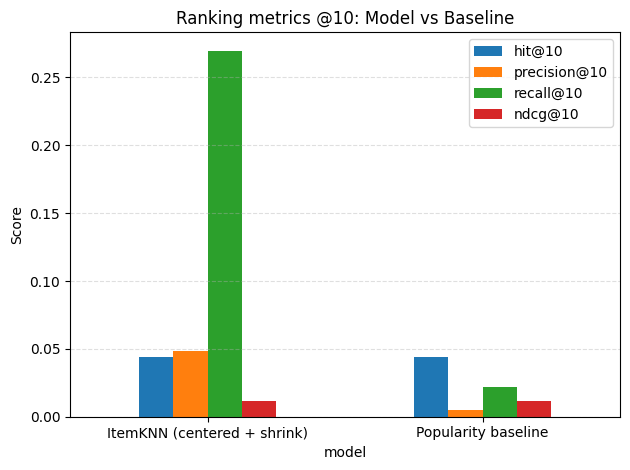

In [94]:
metrics = ["hit@10", "precision@10", "recall@10", "ndcg@10"]
plot_df = results_main[["model"] + metrics].set_index("model")

ax = plot_df.plot(kind="bar", rot = 0)
ax.set_ylabel("Score")
ax.set_title("Ranking metrics @10: Model vs Baseline")
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# Comparison plots

In [207]:
exp = []

def log_exp(name, min_common_users=None, beta=None, rmse=None, coverage=None, hit=None, prec=None, rec=None, ndcg=None):
    exp.append({
        "name": name,
        "min_common_users": min_common_users,
        "beta": beta,
        "rmse": rmse,
        "coverage": coverage,
        "hit@10": hit,
        "precision@10": prec,
        "recall@10": rec,
        "ndcg@10": ndcg,
    })

log_exp("base", min_common_users=2, beta=0, rmse=0.4215375, coverage=0.3747106, hit=0.3664, prec=0.0447, rec=0.2497, ndcg=0.1465)
log_exp("beta5", min_common_users=2, beta=5, rmse=0.4104010, coverage=0.38535879, hit=0.3990, prec=0.0490, rec=0.2751, ndcg=0.1589)
log_exp("beta10", min_common_users=2, beta=10, rmse=0.4100856, coverage=0.3880666, hit=0.4048, prec=0.0494, rec=0.2791, ndcg=0.1667)
log_exp("beta15", min_common_users=2, beta=15, rmse=0.4062273, coverage=0.38535879, hit=0.4083, prec=0.0503, rec=0.2798, ndcg=0.1629)

In [208]:
exp_df = pd.DataFrame(exp)
exp_df


,name,min_common_users,beta,rmse,coverage,hit@10,precision@10,recall@10,ndcg@10
0,base,2,0,0.421538,0.374711,0.3664,0.0447,0.2497,0.1465
1,beta5,2,5,0.410401,0.385359,0.3990,0.0490,0.2751,0.1589
2,beta10,2,10,0.410086,0.388067,0.4048,0.0494,0.2791,0.1667
3,beta15,2,15,0.406227,0.385359,0.4083,0.0503,0.2798,0.1629


In [209]:
print(exp_df.sort_values(["min_common_users","beta"]).to_markdown(index=False))
print(exp_df.sort_values(["min_common_users","beta"]).to_latex(index=False, float_format="%.4f"))


| name   |   min_common_users |   beta |     rmse |   coverage |   hit@10 |   precision@10 |   recall@10 |   ndcg@10 |
|:-------|-------------------:|-------:|---------:|-----------:|---------:|---------------:|------------:|----------:|
| base   |                  2 |      0 | 0.421538 |   0.374711 |   0.3664 |         0.0447 |      0.2497 |    0.1465 |
| beta5  |                  2 |      5 | 0.410401 |   0.385359 |   0.399  |         0.049  |      0.2751 |    0.1589 |
| beta10 |                  2 |     10 | 0.410086 |   0.388067 |   0.4048 |         0.0494 |      0.2791 |    0.1667 |
| beta15 |                  2 |     15 | 0.406227 |   0.385359 |   0.4083 |         0.0503 |      0.2798 |    0.1629 |
\begin{tabular}{lrrrrrrrr}
\toprule
name & min_common_users & beta & rmse & coverage & hit@10 & precision@10 & recall@10 & ndcg@10 \\
\midrule
base & 2 & 0 & 0.4215 & 0.3747 & 0.3664 & 0.0447 & 0.2497 & 0.1465 \\
beta5 & 2 & 5 & 0.4104 & 0.3854 & 0.3990 & 0.0490 & 0.2751 & 0.1589 \\
be

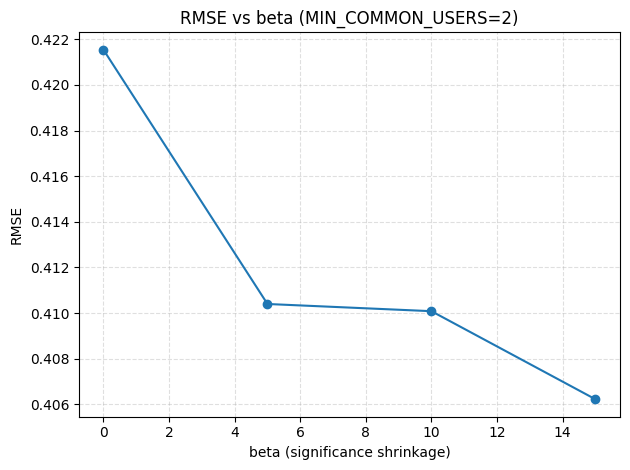

In [210]:
fixed_mcu = 2
d = exp_df[exp_df["min_common_users"] == fixed_mcu].sort_values("beta")

# RMSE vs beta
plt.figure()
plt.plot(d["beta"], d["rmse"], marker="o")
plt.xlabel("beta (significance shrinkage)")
plt.ylabel("RMSE")
plt.title(f"RMSE vs beta (MIN_COMMON_USERS={fixed_mcu})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


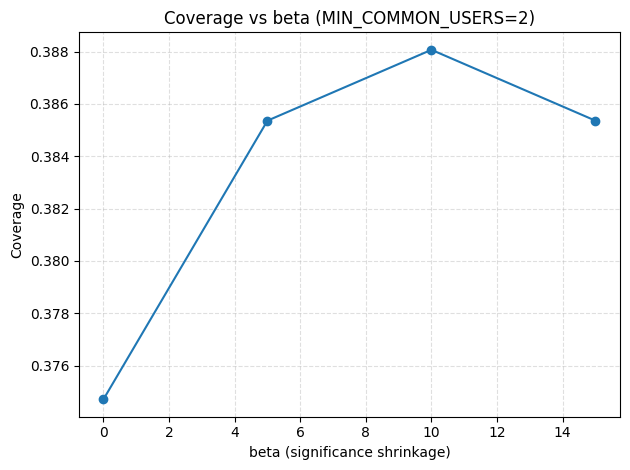

In [211]:
# Coverage vs beta
plt.figure()
plt.plot(d["beta"], d["coverage"], marker="o")
plt.xlabel("beta (significance shrinkage)")
plt.ylabel("Coverage")
plt.title(f"Coverage vs beta (MIN_COMMON_USERS={fixed_mcu})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


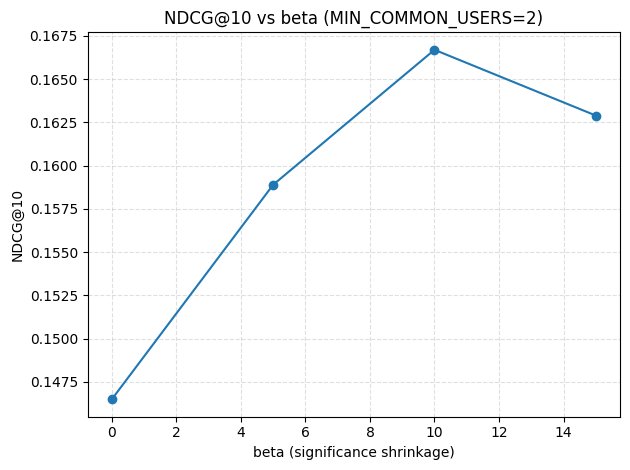

In [212]:
# NDCG@10 vs beta
plt.figure()
plt.plot(d["beta"], d["ndcg@10"], marker="o")
plt.xlabel("beta (significance shrinkage)")
plt.ylabel("NDCG@10")
plt.title(f"NDCG@10 vs beta (MIN_COMMON_USERS={fixed_mcu})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()